# Lesson 4: Document classification

In [173]:
# Gensim loading
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Pretrained models available with gensim
#
# Remark: Since fetching takes time, the model is saved there for future use.
#         None is the default value for a model that has not been loaded
models = {"glove-wiki-gigaword-50" : None,   # 66 MB
          "glove-wiki-gigaword-100": None,   # 128 MB
          "glove-wiki-gigaword-200": None,   # 252 MB
          "glove-twitter-25" : None,   # 104 MB
          "glove-twitter-50" : None,   # 199 MB
          "glove-twitter-100": None,  # 387 MB
         }
modelName = ''

from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
def modelSelection(choice):
    global modelName
    global models
    modelName = choice
    if models[modelName] is not None:
        return
    #
    info = api.info()
    print("Downloading the pre-trained model '%s'..."%modelName)
    models[modelName] = api.load(modelName)  # download the pre-trained model and return it opened as an iterable
    print("Ok")
    return

interact(modelSelection, choice=models.keys() );

interactive(children=(Dropdown(description='choice', options=('glove-wiki-gigaword-50', 'glove-wiki-gigaword-1…

In [174]:
model = models[modelName]

In [201]:
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.cross_validation import train_test_split

In [202]:
newsgroups = fetch_20newsgroups()
docs, y = newsgroups.data, newsgroups.target
names = [ newsgroups.target_names[i] for i in y]

In [203]:
print(newsgroups.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [228]:
i=0
print( "Target: ", y[i])
print( "Target Name: ", names[i])
print( "Document: ")
print( docs[0])

Target:  7
Target Name:  rec.autos
Document: 
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







Cost matrix:


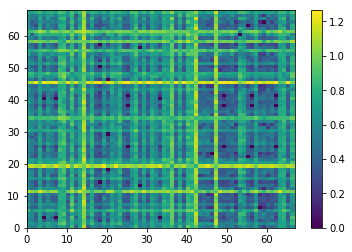

In [213]:
from scipy.spatial import distance

doc1 = docs[0]
doc2 = docs[1]

def doc2words(doc):
    words = doc.split(' ')
    res = []
    for w in words:
        try:
            v = model[w]
            res.append( w )
        except KeyError:
            None
    return res

# Throw away words not in dictionary
w1 = doc2words(doc1)
w2 = doc2words(doc2)

# Compute cost matrix based in similarity of word embeddings
def computeCost(w1, w2):
    N = ( len(w1), len(w2) )
    C = np.ndarray( N )
    for i in range(0, N[0]):
        for j in range(0, N[1]):
            v1 = model[w1[i]]
            v2 = model[w2[j]]
            # See https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
            C[i,j] = distance.cosine(v1, v2)
    return C

C = computeCost(w1, w2)

# Plot of cost matrix
print("Cost matrix:")
plt.clf
plt.pcolormesh(C)
plt.colorbar()

3000
Computing time for Brenier map via Sinkhorn's algorithm: 
 132.263899 ms 

Optimal cost: 
 0.458109 units 

Transport plan:


/home/petitred/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/home/petitred/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log


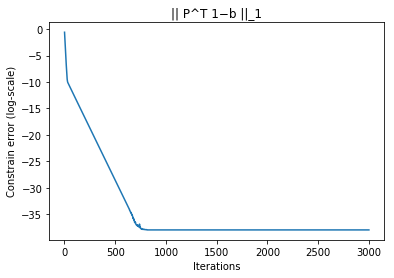

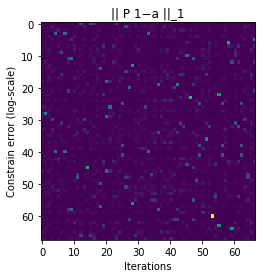

In [246]:
import time
start = time.time()

iter = 3000

def sinkhorn(C, iterations):
    print( iterations )
    N = C.shape
    #Initialize
    a = np.ones(N[0])/N[0]
    b = np.ones(N[1])/N[1]
    epsilon = .05;
    K = np.exp(-C/epsilon)
    # Start
    norm_a = np.zeros(iterations)
    norm_b = np.zeros(iterations)
    ones = np.ones(N[1])
    v = np.ones(N[1])
    u = a / (np.dot(K,v))
    v = b / (np.dot(np.transpose(K),u))
    for i in range(1,iterations):
        # Step 1
        u = a / (np.dot(K,v))
        PT1 = v*np.dot( np.transpose(K), u)
        norm_b[i] = np.linalg.norm( PT1-b, 1)
        # Step 2
        v = b / (np.dot(np.transpose(K),u))
        P1 = u*np.dot( K, v)
        norm_a[i] = np.linalg.norm( P1-a, 1)

    P = np.dot(np.dot(np.diag(u),K),np.diag(v))
    
    plt.figure()
    plt.plot( np.log(norm_b) )
    plt.title( "|| P^T 1−b ||_1" )
    plt.xlabel('Iterations')
    plt.ylabel('Constrain error (log-scale)')

    plt.figure()
    plt.title( "|| P 1−a ||_1" )
    plt.xlabel('Iterations')
    plt.ylabel('Constrain error (log-scale)')
    plt.plot( np.log(norm_a) )

    return P

P = sinkhorn(C, iterations=iter)

end = time.time()
print("Computing time for Brenier map via Sinkhorn's algorithm: \n %f ms \n" % ((end - start)*1000) )
cost = np.tensordot(P,C)
print("Optimal cost: \n %f units \n" % cost)
print("Transport plan:")
plt.figure()
plt.clf
plt.imshow(P)

In [245]:
def computeDocDistance( doc1, doc2):
    # Throw away words not in dictionary
    w1 = doc2words(doc1)
    w2 = doc2words(doc2)
    # Compute cost matrix based in similarity of word embeddings
    C = computeCost(w1, w2)
    # Sinkhorn
    P = sinkhorn(C, iterations=1000)
    return np.tensordot(P,C)

import time
start = time.time()

count = 6
index1 = np.where( y == 4 )
index2 = np.where( y == 15 )
index1 = index1[0][:(count//2)]
index2 = index2[0][:(count//2)]
docSubset = [docs[i] for i in index1] + [docs[i] for i in index2]
OT = np.ndarray( (count, count) )
for i in range(0, count):
    for j in range(0, count):
        if i==j:
            OT[i,j] = 0
        elif j<i:
            OT[i,j] = OT[j,i]
        else:
            OT[i,j] = computeDocDistance( docSubset[i], docSubset[j])

end = time.time()
print("Computing time for distances: \n %f ms \n" % ((end - start)*1000) )

Computing time for distances: 
 27121.771574 ms 



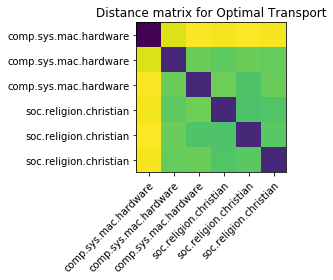

In [244]:
# Plot of distances
fig, ax = plt.subplots()
im = ax.imshow(OT)

# We want to show all ticks...
ax.set_xticks(np.arange(count))
ax.set_yticks(np.arange(count))
# ... and label them with the respective list entries
namesSubset = [names[i] for i in index1] + [names[i] for i in index2]
ax.set_xticklabels( namesSubset )
ax.set_yticklabels( namesSubset )

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Distance matrix for Optimal Transport")
fig.tight_layout()
plt.show()

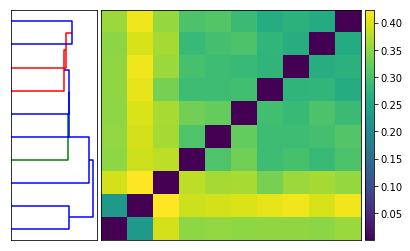

In [225]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch

# Compute and plot dendrogram.
fig = pylab.figure()
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = sch.linkage(OT, method='centroid')
Z = sch.dendrogram(Y, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
OT = OT[index,:]
OT = OT[:,index]
im = axmatrix.matshow(OT, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pylab.colorbar(im, cax=axcolor)

# Display and save figure.
fig.show()

In [226]:
print(OT)

[[1.19228834e-06 2.28607748e-01 3.95629158e-01 3.51709033e-01
  3.55046010e-01 3.50880067e-01 3.52612524e-01 3.52280229e-01
  3.49978185e-01 3.60392639e-01]
 [2.28612164e-01 5.82966514e-09 4.23327114e-01 3.90893270e-01
  3.95889302e-01 3.99571822e-01 4.07883310e-01 4.13470133e-01
  3.97900671e-01 4.14294358e-01]
 [3.95629158e-01 4.23327114e-01 1.07355696e-08 3.80763584e-01
  3.65798334e-01 3.68461052e-01 3.36346240e-01 3.60300270e-01
  3.65657027e-01 3.55903235e-01]
 [3.51709033e-01 3.90893270e-01 3.80763584e-01 2.63921301e-06
  3.07154953e-01 3.33876523e-01 2.91624863e-01 2.99833298e-01
  2.85308091e-01 3.05737587e-01]
 [3.55046010e-01 3.95889302e-01 3.65798334e-01 3.07154953e-01
  2.04798992e-07 3.23892901e-01 2.91168866e-01 2.92127068e-01
  2.98601582e-01 3.10548042e-01]
 [3.50880067e-01 3.99536981e-01 3.68447557e-01 3.33876523e-01
  3.23892901e-01 3.11741360e-06 2.95688314e-01 2.86647613e-01
  3.04905128e-01 2.89193046e-01]
 [3.52612524e-01 4.07883310e-01 3.36323779e-01 2.91624863e